In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import tensorflow as tf
tf.compat.v1.enable_eager_execution
from keras.models import Model, load_model
from keras.layers import Lambda, Input, Dense
from keras.losses import binary_crossentropy, kl_divergence
from keras.losses import MeanSquaredError as mse
from keras import optimizers

from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt

from argparse import Namespace
from pathlib import Path
from collections import OrderedDict
import sklearn
from sklearn import preprocessing
import os

In [2]:
raw_dt = pd.read_csv("data/realKnownCause/realKnownCause/machine_temperature_system_failure.csv")
# raw_dt = pd.read_csv(datafile_path)
raw_dt.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


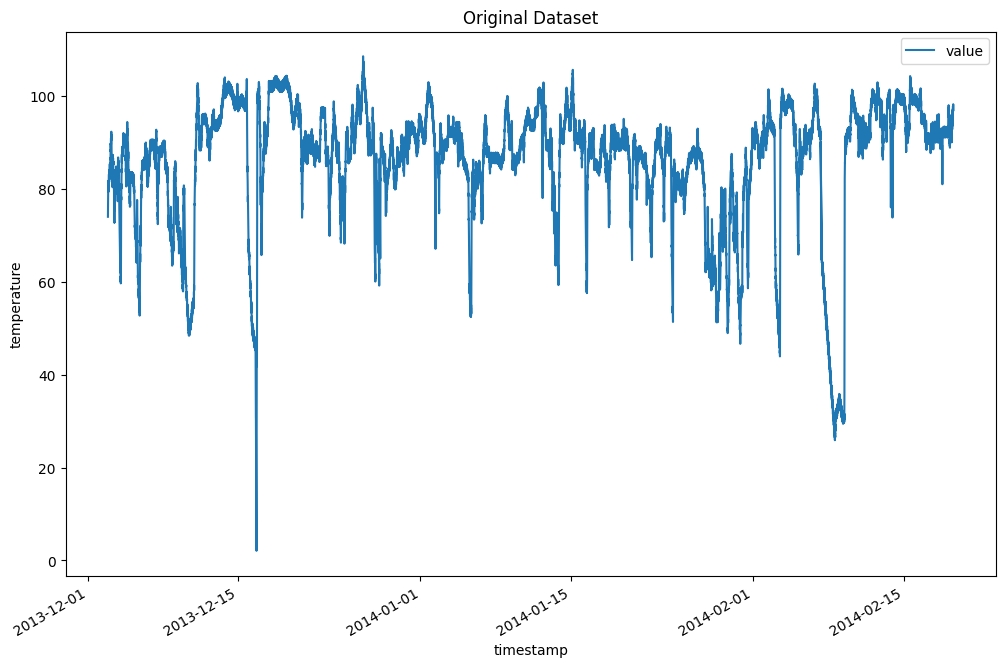

In [3]:
data = raw_dt.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.plot(x='timestamp', y='value', figsize=(12, 8))
plt.ylabel("temperature")
plt.title("Original Dataset");

In [4]:
data['day'] = data['timestamp'].dt.day
data['month'] = data['timestamp'].dt.month
data['hour_min'] = data['timestamp'].dt.hour + data['timestamp'].dt.minute / 60

data['day_of_week'] = data['timestamp'].dt.dayofweek
data['holiday'] = 0
data.loc[(data['day'] == 25) & (data['month'] == 12),'holiday'] = 1  # Christmas
data.loc[(data['day'] == 1) & (data['month'] == 1),'holiday'] = 1  # New Year's Day
data.head()

,timestamp,value,day,month,hour_min,day_of_week,holiday
0,2013-12-02 21:15:00,73.967322,2,12,21.250000,0,0
1,2013-12-02 21:20:00,74.935882,2,12,21.333333,0,0
2,2013-12-02 21:25:00,76.124162,2,12,21.416667,0,0
3,2013-12-02 21:30:00,78.140707,2,12,21.500000,0,0
4,2013-12-02 21:35:00,79.329836,2,12,21.583333,0,0


In [5]:
holidays = data.loc[data['holiday'] == 1, 'timestamp'].dt.date.unique()
holidays

array([datetime.date(2013, 12, 25), datetime.date(2014, 1, 1)],
      dtype=object)

In [6]:
for i, hd in enumerate(holidays):
    data['hol_' + str(i)] = data['timestamp'].dt.date - hd

In [7]:
for i in range(data.shape[0]):
    if np.abs(data.loc[data.index[i], 'hol_0']) <= np.abs(data.loc[data.index[i], 'hol_1']):
        data.loc[data.index[i], 'gap_holiday'] = data.loc[data.index[i], 'hol_0']
    else:
        data.loc[data.index[i], 'gap_holiday'] = data.loc[data.index[i], 'hol_1']

In [8]:
data['gap_holiday'] = data['gap_holiday'].dt.days
data.drop(['hol_0', 'hol_1'], axis=1, inplace=True)
data['t'] = (data['timestamp'].astype(np.int64)/1e11).astype(np.int64)
data.drop('timestamp', axis=1, inplace=True)
data

,value,day,month,hour_min,day_of_week,holiday,gap_holiday,t
0,73.967322,2,12,21.250000,0,0,-23,13860189
1,74.935882,2,12,21.333333,0,0,-23,13860192
2,76.124162,2,12,21.416667,0,0,-23,13860195
3,78.140707,2,12,21.500000,0,0,-23,13860198
4,79.329836,2,12,21.583333,0,0,-23,13860201
...,...,...,...,...,...,...,...,...
22690,98.185415,19,2,15.083333,2,0,49,13928223
22691,97.804168,19,2,15.166667,2,0,49,13928226
22692,97.135468,19,2,15.250000,2,0,49,13928229
22693,98.056852,19,2,15.333333,2,0,49,13928232


In [9]:
cont_vars = ['value', 'hour_min', 'gap_holiday', 't']
cat_vars = ['day', 'month', 'day_of_week', 'holiday']

In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoders = [LabelEncoder() for _ in cat_vars] 
for col, enc in zip(cat_vars, label_encoders):
    data[col] = enc.fit_transform(data[col])
    
data

,value,day,month,hour_min,day_of_week,holiday,gap_holiday,t
0,73.967322,1,2,21.250000,0,0,-23,13860189
1,74.935882,1,2,21.333333,0,0,-23,13860192
2,76.124162,1,2,21.416667,0,0,-23,13860195
3,78.140707,1,2,21.500000,0,0,-23,13860198
4,79.329836,1,2,21.583333,0,0,-23,13860201
...,...,...,...,...,...,...,...,...
22690,98.185415,18,1,15.083333,2,0,49,13928223
22691,97.804168,18,1,15.166667,2,0,49,13928226
22692,97.135468,18,1,15.250000,2,0,49,13928229
22693,98.056852,18,1,15.333333,2,0,49,13928232


In [11]:
# Splitting to train and test
test_ratio = 0.3
tr_data = data.iloc[: int(len(data) * (1 - test_ratio))]
tst_data = data.iloc[int(len(data) * (1 - test_ratio)) :]

In [12]:
scaler = preprocessing.StandardScaler().fit(tr_data[cont_vars])

In [13]:
tr_data_scaled = tr_data.copy()
tr_data_scaled[cont_vars] = scaler.transform(tr_data[cont_vars])
tst_data_scaled = tst_data.copy()
tst_data_scaled[cont_vars] = scaler.transform(tst_data[cont_vars])

In [14]:
train= pd.get_dummies(tr_data_scaled.iloc[:,:], columns= cat_vars )
train.head()

,value,hour_min,gap_holiday,t,day_0,day_1,day_2,day_3,day_4,day_5,...,month_2,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,holiday_0,holiday_1
0,-1.224398,1.336685,-1.866199,-1.732808,False,True,False,False,False,False,...,True,True,False,False,False,False,False,False,True,False
1,-1.134136,1.348691,-1.866199,-1.732590,False,True,False,False,False,False,...,True,True,False,False,False,False,False,False,True,False
2,-1.023399,1.360698,-1.866199,-1.732372,False,True,False,False,False,False,...,True,True,False,False,False,False,False,False,True,False
3,-0.835474,1.372704,-1.866199,-1.732153,False,True,False,False,False,False,...,True,True,False,False,False,False,False,False,True,False
4,-0.724658,1.384711,-1.866199,-1.731935,False,True,False,False,False,False,...,True,True,False,False,False,False,False,False,True,False


In [15]:
train= train.to_numpy()
train= np.asarray(train).astype(np.float32)

In [16]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [17]:
def sample(args):
    z_mean, z_log_var = args
    batch = tf.keras.backend.shape(z_mean)[0]
    dim = tf.keras.backend.int_shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

In [18]:
class VAELossLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        x, x_decoded_mean, z_mean, z_log_var = inputs
        # compute the average MSE error, then scale it up, i.e. simply sum on all axes
        reconstruction_loss = tf.reduce_sum(tf.square(x - x_decoded_mean))
        # compute the KL loss
        kl_loss = - 0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        # return the average loss over all 
        total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)    
        self.add_loss(total_loss)
        return x  # Dummy output

In [19]:
original_dim = train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

In [20]:
print(input_shape)

(46,)


In [21]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 46)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 23)        │      1,081 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 15)        │        360 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 15)        │        360 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 15)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,801 (7.04 KB)

 Trainable params: 1,801 (7.04 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)         │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 23)             │           368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 46)             │         1,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,472 (5.75 KB)

 Trainable params: 1,472 (5.75 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# full VAE model
inputs = Input(shape=input_shape, name='encoder_input')

x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# Use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')

# Decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name='decoder')

outputs = decoder(encoder(inputs))
vae_loss_layer = VAELossLayer()([inputs, outputs, z_mean, z_log_var])

vae_model = Model(inputs, [outputs, vae_loss_layer], name='vae_mlp')

In [24]:
opt = optimizers.Adam(learning_rate=0.0001, clipvalue=0.5)
#opt = optimizers.RMSprop(learning_rate=0.0001)

vae_model.compile(optimizer=opt, loss=lambda y_true, y_pred: y_pred)
vae_model.summary()
# Finally, we train the model:
results = vae_model.fit(train,train, 
                        shuffle=True,
                        epochs=100,
                        batch_size=256)

Model: "vae_mlp"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 46)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, 15)        │      1,801 │ encoder_input[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 23)        │      1,081 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 46)        │      1,472 │ encoder[0][0]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 15)        │        360 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 15)        │        360 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer      │ (None, 46)        │          0 │ encoder_input[0]… │
│ (VAELossLayer)      │                   │            │ decoder[0][0],    │
│                     │                   │            │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,273 (12.79 KB)

 Trainable params: 3,273 (12.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3921.8401
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3720.1377
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3497.7129
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3305.7014
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3094.2358
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2864.5977
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2631.4409
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2410.4944
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2198.5769
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2020.1490
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1866.5884
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1737.4578
Epoch 13/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1641.9567
Epoch 14/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1566.3430
Epoch 15/100
63/63 ━━━━━━━━━━

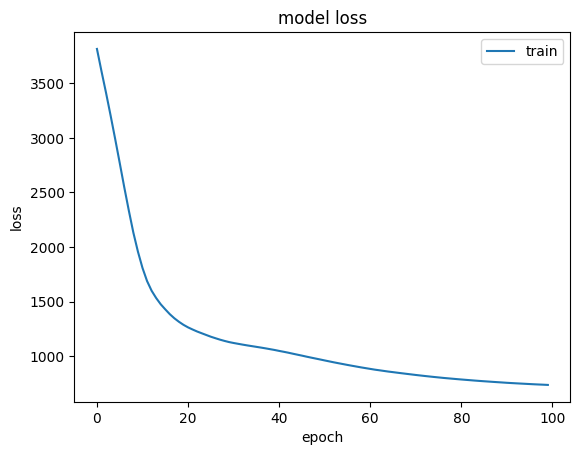

In [25]:
plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [26]:
train_pred = vae_model.predict(train)[0]

497/497 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step


In [27]:
mae_vector = get_error_term(train_pred, train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)

Avg error 0.06747893989086151
median error 0.05932922661304474
99Q: 0.15496296584606167
setting threshold on 0.15496296584606167 
